<a href="https://colab.research.google.com/github/MyWhiteCastle/BME-Project2/blob/master/DenseNet_BC_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# packages preloading
## packages for dataset and image preprocessing
from tensorflow.keras.datasets import cifar10,cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## packages for modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras import regularizers
import math

## visualization & file saving
from matplotlib import pyplot as plt
import pickle 

## version checking
print (tf.keras.__version__)
print (tf.__version__)

2.2.4-tf
1.15.0


Using TensorFlow backend.


#Loading Dataset

In [0]:
# function for data augmentation
def getDataGenerator(train_phase):
    if train_phase == True:
        datagen = ImageDataGenerator(
        rotation_range=0.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        channel_shift_range=0.,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None)
    else: 
        datagen = ImageDataGenerator(
        rescale=None
        )

    return datagen


## - Cifar10

In [0]:
# define DenseNet parms Cifar10
nb_classes = 10
img_dim = (32,32,3)

batch_size = 64
nb_epoch = 40

In [0]:
# datasets with data augmentation
(x_train,y_train),(x_test,y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test= keras.utils.to_categorical(y_test, nb_classes)

# hold out 5000 samples from training for validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size=0.1, random_state=42)

train_datagen = getDataGenerator(train_phase=True)
train_datagen = train_datagen.flow(x_train,y_train,batch_size = batch_size)

validation_datagen = getDataGenerator(train_phase=False)
validation_datagen = validation_datagen.flow(x_val,y_val,batch_size = batch_size)

In [0]:
# dataset without data augmentation
(x_train,y_train),(x_test,y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test= keras.utils.to_categorical(y_test, nb_classes)

# hold out 5000 samples from training for validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size=0.1, random_state=42)

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
print(x_train.shape,y_train.shape)
print(x_tr.shape,y_tr.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)


(50000, 32, 32, 3) (50000, 10)
(45000, 32, 32, 3) (45000, 10)
(5000, 32, 32, 3) (5000, 10)
(10000, 32, 32, 3) (10000, 10)


## - Cifar100

In [0]:
# define DenseNet parms Cifar10
nb_classes = 100
img_dim = (32,32,3)

batch_size = 64
nb_epoch = 40

In [0]:
# datasets with data augmentation
(x_train,y_train),(x_test,y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test= keras.utils.to_categorical(y_test, nb_classes)

# hold out 5000 samples from training for validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size=0.1, random_state=42)

train_datagen = getDataGenerator(train_phase=True)
train_datagen = train_datagen.flow(x_train,y_train,batch_size = batch_size)

validation_datagen = getDataGenerator(train_phase=False)
validation_datagen = validation_datagen.flow(x_val,y_val,batch_size = batch_size)

In [0]:
# datasets without data augmentation
(x_train,y_train),(x_test,y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test= keras.utils.to_categorical(y_test, nb_classes)

# hold out 5000 samples from training for validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size=0.1, random_state=42)

In [0]:
print(x_train.shape,y_train.shape)
print(x_tr.shape,y_tr.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)


# Modeling

## Model Functions

In [0]:
# define chuncks of model 
def conv_layer(inputs,filters,kernel_size,strides,dropout_rate=None,weight_decay=1E-4):
    """single convolution 2D with pre-activation"""
  
    ## pre-activation BN and ReLU
    bn_axis = 1 if K.image_data_format() == "th" else -1
  
    x = layers.BatchNormalization(axis = bn_axis, epsilon=1.1e-5)(inputs)
    x = layers.Activation('relu')(x)
  
    ## conv2D layer with padding = 'same'
    outputs = layers.Conv2D(filters = filters, kernel_size = kernel_size,strides = strides, 
                            kernel_initializer="he_uniform", padding = 'same', use_bias=False,
                            kernel_regularizer = regularizers.l2(weight_decay))(x)
  
    ## dropout layer after convolutional layers except the first conv layer (for dataset without data augmentation)
    if dropout_rate is not None: 
        outputs = layers.Dropout(dropout_rate)(outputs)
  
    return outputs

def bottleneck_layer(inputs,filters):
    """bottleneck layer with pre-activation"""
    ## pre-activation BN and ReLU
    bn_axis = 1 if K.image_data_format() == "th" else -1
  
    x = layers.BatchNormalization(axis = bn_axis, epsilon=1.1e-5)(inputs)
    x = layers.Activation('relu')(x)
  
    ## conv2D layer with kernel size 1 x 1
    ### number of feature maps of bottleneck layer = 4k 
    nb_filter = 4 * filters
    outputs = layers.Conv2D(filters = nb_filter, kernel_size = (1,1),strides = (1,1), padding = 'same')(x)
  
    return outputs  

def conv_block(inputs,filters):
    """conv block consisting of a bottleneck layer and a convolution layer with kernel size 3x3"""
  
    kernel_size = (3,3)
    strides = (1,1)
  
    x = bottleneck_layer(inputs,filters)
    outputs = conv_layer(x,filters,kernel_size,strides)
    
  
    return outputs

def dense_block(inputs,nb_filter,growth_rate, nb_conv_block):
    """a convolutional block with multiple conv blocks and concatenation for outputs of each conv block 
       key innovation for DenseNet
    """
    concat_axis = 1 if K.image_data_format() == "th" else -1

    # x_list is created for storage purpose
    x_list = [inputs]
  
    for i in range(nb_conv_block):
        outputs = conv_block(inputs, growth_rate)
        x_list.append(outputs)
        inputs = layers.concatenate([inputs,outputs],concat_axis)
    
        nb_filter +=growth_rate

    return inputs,nb_filter,x_list

def transition_block(inputs,nb_filter,theta,dropout_rate):
    """a block that consists of one bottleneck conv layer and a pooling layer
       to furhter improve model compactness
    """
    
    #compression parameter to reduce number of channels/filters
    ## theta = 1 for no compression
    ## theta = 0.5 for DenseNet-BC
  
    x = conv_layer(inputs,math.floor(nb_filter * theta),(1,1),(1,1),dropout_rate)
    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
  
    return x, math.floor(nb_filter * theta)

# define the model 
def DenseNet(inputs,init_nb_filters,growth_rate,nb_layers,theta,dropout_rate,weight_decay):
    """the actual DenseNet model"""
    ## The initial convolution layer comprises 2k convolutions of size 3 x 3 with stride 1
    x = conv_layer(inputs,init_nb_filters,(3,3),(1,1))

    ## Dense Block (1) + Transition Block (1)
    x,nb_filters,x_list_ = dense_block(x,init_nb_filters,growth_rate,nb_layers)
    x,nb_filters = transition_block(x, nb_filters,theta, dropout_rate)

    ## Dense Block (2) + Transition Block (2)
    x,nb_filters,x_list_ = dense_block(x,nb_filters,growth_rate,nb_layers)
    x,nb_filters = transition_block(x, nb_filters,theta, dropout_rate)

    ## Dense Block (3)
    x,nb_filters,x_list_ = dense_block(x,nb_filters,growth_rate,nb_layers)

    ## Global Average Pooling 
    x = layers.GlobalAveragePooling2D()(x)

    ## FC classification layer
    x = layers.Dense(nb_classes, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay), bias_regularizer=regularizers.l2(weight_decay))(x)

    return x


## Model Hyperparamters

In [0]:
# hyperparameters
## growth rate =k 
growth_rate = 12


## initial number of output channels
### DenseNet-B: 16
### DenseNet-BC: 2 * growth_rate
init_nb_filters = 24


## same number of layers in each dense block
depth = 40
nb_layers = 16


## dropout rate 
### DenseNet with data augmentation
dropout_rate = None
### DenseNet without data augmentation
### dropout_rate = 0.2

## weight decay 
weight_decay=1E-4

## theta 
theta = 0.5

## Model Setup

### DenseNet-BC-100-12 with data augmentation
- dropout_rate = None


In [0]:
# DenseNet-BC setup

## input images 32 x 32
inputs = keras.Input(img_dim)

## call DenseNet-BC-100-12 with data augmentation
outputs = DenseNet(inputs,init_nb_filters,growth_rate,nb_layers,theta,dropout_rate,weight_decay)

## assign the actual model
model = keras.Model(inputs,outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 3)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         activation[0][0]                 
______________________________________________________________________________________________

In [0]:
# DenseNet-BC setup

## input images 32 x 32
inputs = keras.Input(img_dim)

## call DenseNet-BC-100-12 without data augmentation with dropout rate of 0.2
dropout_rate = 0.2
outputs = DenseNet(inputs,init_nb_filters,growth_rate,nb_layers,theta,dropout_rate,weight_decay)

## assign the actual model
model = keras.Model(inputs,outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 3)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         activation[0][0]                 
______________________________________________________________________________________________

## Model Training

In [0]:
# training parameters
## define learning rate decay rule
def scheduler(epoch):
    """learning rate decay for 40 epoch
    - 50% of epoch: 0.1 
    50% -75% of epoch: 0.01 
    70% - of epoch: 0.001
    """
    if epoch < 20:
        return 0.1
    if epoch < 30:
        return 0.01
    return 0.001

In [0]:
# actual training 
## define optimizer:SGD 
optimizer = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

## define callbacks
model_checkpoint = keras.callbacks.ModelCheckpoint('densenet_100_12.h5', monitor="val_acc", save_best_only=True,
                                  save_weights_only=True, verbose=1)

## set callback
change_lr = keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [change_lr,model_checkpoint]

## feed all settings into the model to train
history = model.fit_generator(generator=train_datagen,
                steps_per_epoch= x_tr.shape[0] // batch_size,
                epochs=nb_epoch,b
                callbacks=callbacks,
                validation_data=validation_datagen,
                validation_steps = x_val.shape[0] // batch_size,
                verbose=1)


Epoch 1/40
 78/703 [==>...........................] - ETA: 1:33 - loss: 2.1011 - acc: 0.3602
Epoch 00001: val_acc improved from -inf to 0.36018, saving model to densenet_100_12.h5
703/703 [==============================] - 401s 570ms/step - loss: 1.7246 - acc: 0.4419 - val_loss: 2.1011 - val_acc: 0.3602
Epoch 2/40
 78/703 [==>...........................] - ETA: 1:14 - loss: 1.3462 - acc: 0.6024
Epoch 00002: val_acc improved from 0.36018 to 0.60236, saving model to densenet_100_12.h5
703/703 [==============================] - 319s 454ms/step - loss: 1.1469 - acc: 0.6549 - val_loss: 1.3462 - val_acc: 0.6024
Epoch 3/40
 78/703 [==>...........................] - ETA: 1:14 - loss: 1.3593 - acc: 0.6274
Epoch 00003: val_acc improved from 0.60236 to 0.62740, saving model to densenet_100_12.h5
703/703 [==============================] - 318s 453ms/step - loss: 0.9271 - acc: 0.7358 - val_loss: 1.3593 - val_acc: 0.6274
Epoch 4/40
 78/703 [==>...........................] - ETA: 1:14 - loss: 1.0955 

In [0]:
# actual training 
## define optimizer:SGD 
optimizer = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

## define callbacks
model_checkpoint = keras.callbacks.ModelCheckpoint('densenet_100_12_dropout.h5', monitor="val_acc", save_best_only=True,
                                  save_weights_only=True, verbose=1)

## set callback
change_lr = keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [change_lr,model_checkpoint]

## feed all settings into the model to train
history = model.fit(x_tr,y_tr,
                   epochs=nb_epoch,
                   callbacks=callbacks,
                    validation_data = (x_val,y_val),
                    verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/40
44992/45000 [============================>.] - ETA: 0s - loss: 1.7691 - acc: 0.4161
Epoch 00001: val_acc improved from -inf to 0.41380, saving model to densenet_100_12_dropout.h5
45000/45000 [==============================] - 429s 10ms/sample - loss: 1.7691 - acc: 0.4161 - val_loss: 2.1730 - val_acc: 0.4138
Epoch 2/40
44992/45000 [============================>.] - ETA: 0s - loss: 1.2433 - acc: 0.6150
Epoch 00002: val_acc improved from 0.41380 to 0.55180, saving model to densenet_100_12_dropout.h5
45000/45000 [==============================] - 344s 8ms/sample - loss: 1.2434 - acc: 0.6150 - val_loss: 1.5310 - val_acc: 0.5518
Epoch 3/40
44992/45000 [============================>.] - ETA: 0s - loss: 1.0171 - acc: 0.7027
Epoch 00003: val_acc improved from 0.55180 to 0.64040, saving model to densenet_100_12_dropout.h5
45000/45000 [==============================] - 344s 8ms/sample - loss: 1.0171 - acc: 0.7027 - val_loss: 1.2309 - val

In [0]:
with open('/trainHistory10012dropout', 'wb') as f:
    pickle.dump(history.history, f)

# Results

## Model Evaluation on Testset

In [0]:
# accuracy on test set using DenseNet-BC-100-12 with data augmentation
accuracy_bc_100_12_aug = model.evaluate(x_test,y_test,batch_size)
print(accuracy_bc_100_12_aug)

10000/10000 [==============================] - 18s 2ms/sample - loss: 0.4094 - acc: 0.9188
[0.40941992235183716, 0.9188]


In [0]:
# accuracy on test set using DenseNet-BC-100-12 without data augmentation
accuracy_bc_100_12_dropout = model.evaluate(x_test,y_test,batch_size)
print(accuracy_bc_100_12_dropout)

10000/10000 [==============================] - 19s 2ms/sample - loss: 0.6428 - acc: 0.8959
[0.642806273841858, 0.8959]


## Training and Validation Accuracy Plot

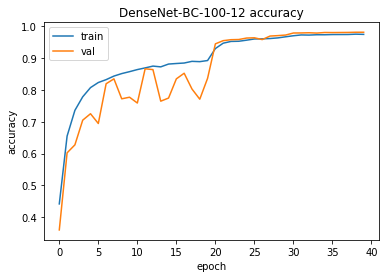

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('DenseNet-BC-100-12 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/model accuracy BC-100-12.png')


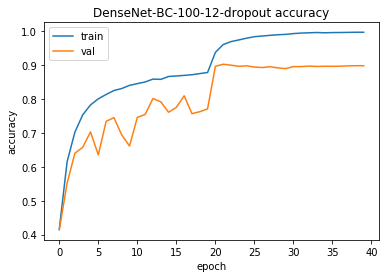

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('DenseNet-BC-100-12-dropout accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/model accuracy BC-100-12-dropout.png')

## Training and Validation Loss Plot

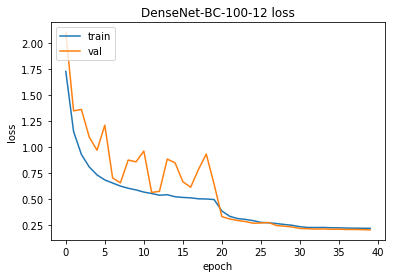

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet-BC-100-12 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/model loss BC-100-12.png')


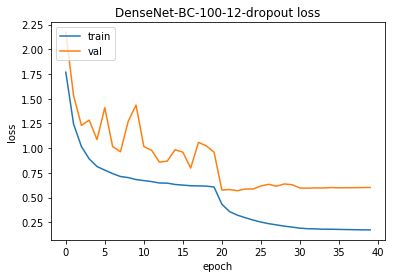

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet-BC-100-12-dropout loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/model loss BC-100-12-dropout.png')
